In [ ]:
%pip install TSB-UAD

: 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.models.feature import Window
from TSB_UAD.models.iforest import IForest
from TSB_UAD.vus.metrics import get_metrics

Matplotlib is building the font cache; this may take a moment.


In [2]:
public_root = "./data/TSB-UAD-Public"
selected_domains = ['NASA-MSL', 'IOPS', 'Genesis', 'YAHOO']

# For each domain, pick the 1st ts file
series_list, label_list = [], []
for dom in selected_domains:
    dom_path = os.path.join(public_root, dom)
    files = [f for f in os.listdir(dom_path) if f.endswith('.out')]
    chosen = files[0]
    df = (pd.read_csv(os.path.join(dom_path, chosen),
                      header=None)
            .dropna()
            .to_numpy())
    data = df[:, 0].astype(float)
    label = df[:, 1].astype(int)
    series_list.append(data)
    label_list.append(label)

norm1_ts = series_list[0]
norm1_labels = label_list[0]
norm2_ts = np.concatenate([series_list[0],series_list[1]], axis=0)
norm2_labels = np.concatenate([label_list[0],label_list[1]], axis=0)
norm3_ts = np.concatenate([series_list[0],series_list[1],series_list[2]], axis=0)
norm3_labels = np.concatenate([label_list[0],label_list[1],label_list[2]], axis=0)
norm4_ts = np.concatenate(series_list, axis=0)
norm4_labels = np.concatenate(label_list, axis=0)

series = [norm1_ts, norm2_ts, norm3_ts, norm4_ts]
labels = [norm1_labels, norm2_labels, norm3_labels, norm4_labels]

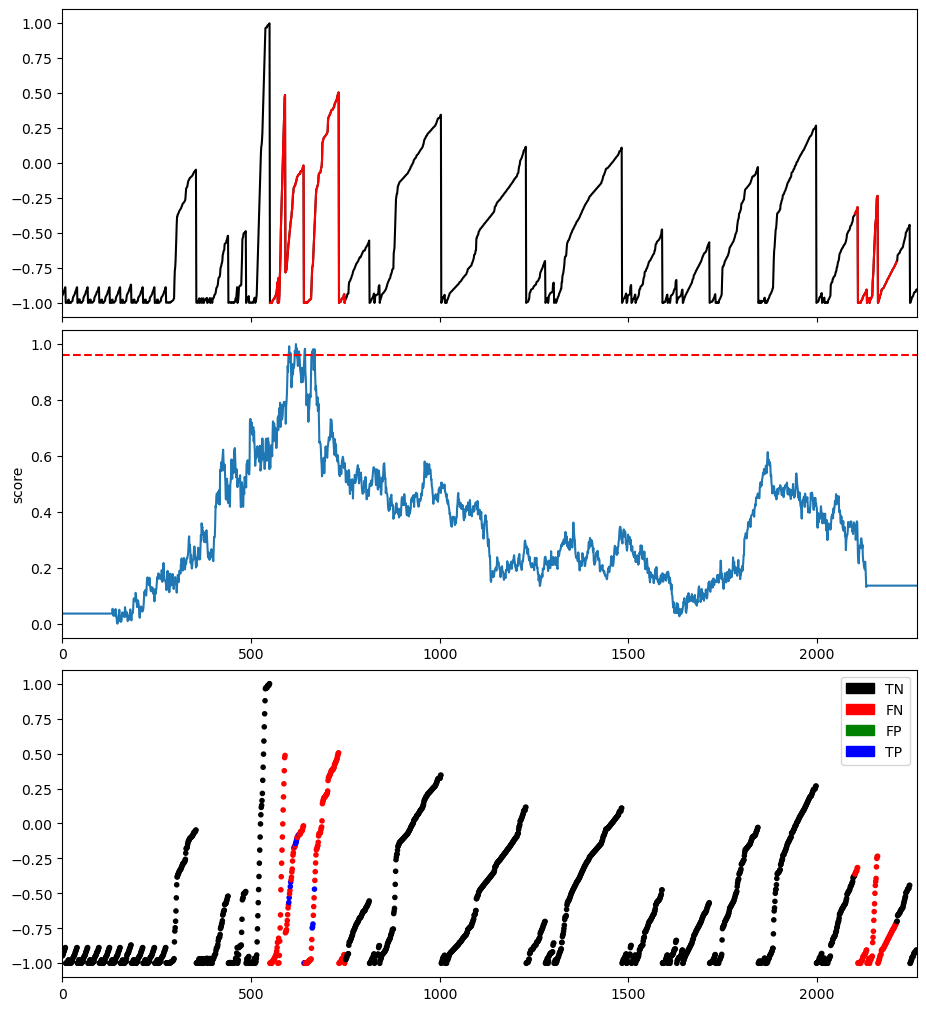

AUC_ROC             : 0.7357
AUC_PR              : 0.6492
Precision           : 1.0000
Recall              : 0.0513
F                   : 0.0976
Precision_at_k      : 0.0513
Rprecision          : 1.0000
Rrecall             : 0.1040
RF                  : 0.1884
R_AUC_ROC           : 0.9197
R_AUC_PR            : 0.7741
VUS_ROC             : 0.8342
VUS_PR              : 0.6471
Affiliation_Precision: 0.7060
Affiliation_Recall  : 0.8111


In [3]:
# Perform IForest on the first time series
data  = series[0]              
label = labels[0]           

slidingWindow = find_length(data)               
X_data        = Window(window=slidingWindow) \
                    .convert(data) \
                    .to_numpy() 

clf = IForest(n_jobs=2,            
              random_state=42)      
clf.fit(X_data)                     # unsupervised fit

scores = clf.decision_scores_      # shape = (n_windows,)

# align scores with original time-series length
scores = MinMaxScaler(feature_range=(0,1)) \
            .fit_transform(scores.reshape(-1,1)) \
            .ravel()

# pad so scores[i] aligns with data[i]
pad_before = math.ceil((slidingWindow-1)/2)
pad_after  = (slidingWindow-1)//2
scores = np.concatenate([
    np.full(pad_before, scores[0]),
    scores,
    np.full(pad_after,  scores[-1])
])

plotFig(data, label, scores,
        slidingWindow=slidingWindow,
        fileName="norm1_ts",
        modelName="IForest")
plt.show()

results = get_metrics(scores,
                      label,
                      metric="all",
                      slidingWindow=slidingWindow)

for m, v in results.items():
    print(f"{m:20s}: {v:.4f}")
